# Question 1

In this question we will:

- Implement a segmentation algorithm that uses random walker as the primary means to segment a noisy version of the leaf dataset from the previous assignment.
- Evaluate the performance of our algorithm in terms of mean Dice coefficient.
- Examine the best and worst results that we get from the dataset.
- Reason on why the algorithm works well on the 'best' cases and what causes it to fail on the 'worst' cases.



# Step 1: Write your Segmentation Algorithm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  You may add additional parameters besides the image to be segmented if you wish.  Your algorithm must use the random-walker segmentation (``skimage.segmentation.random_walker()``) and you should consider doing some region processing after segmentation to improve the result.

Let's assume that, for the purposes of this, that de-noising the images would be too expensive because
our application has to run on a mobile device.   Thus, you are not allowed to denoise the images before applying the
random walker algorithm.

_Hint: The challenge here is to automatically find suitable foreground and background markers for the random walker algorithm.  The noisy images make for an additional challenge, but that's why we're using random walker; becuase of its robustness to noise._

_Hint: When you use `random_walker()` on a color image, make sure to set `channel_axis=2`._

_Hint: you may need to adjust the `beta` and `tol` arguments to the `ramdom_walker()` function to get excellent results._

_Hint: Output of the `random_walker()` function may be further post-processed using region processing methods._

In [312]:
import os as os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import color, morphology, io
from skimage.measure import label, regionprops
from skimage.segmentation import random_walker
from skimage.util import img_as_bool

In [313]:
def segleaf(I):
    """
    Segment the green leaf area from an RGB image using HSV thresholds and the random walker algorithm.

    Parameters:
    I : numpy.ndarray
        Input RGB image.

    Returns:
    numpy.ndarray
        Binary mask of the segmented leaf with dtype=bool.
    """
    # Convert the image to HSV
    I_hsv = color.rgb2hsv(I)

    # Initialize markers
    markers = np.zeros_like(I[:, :, 0])

    # Set markers for the background
    markers[I_hsv[:, :, 1] < 0.1] = 1  # Low saturation aiming to select the white background

    # Set markers for the leaf aiming for the green color
    markers[
        (I_hsv[:, :, 0] > 0.25) & (I_hsv[:, :, 0] < 0.4) 
        & (I_hsv[:, :, 1] > 0.3)
    ] = 2

    segmentation = random_walker(I, markers, beta=80, mode='bf', channel_axis=2)

    segmentation = morphology.remove_small_holes(segmentation == 2, area_threshold=64)
    segmentation = morphology.remove_small_objects(segmentation, min_size=1000)

    # Label and keep the largest connected component (to remove other objects that are not the leaf but were detected)
    segmentation = label(segmentation)
    properties = regionprops(segmentation)

    if len(properties) > 1:
        areas = [prop.area for prop in properties]
        largest_idx = np.argmax(areas) + 1
        segmentation = segmentation == largest_idx

    return segmentation.astype(bool)

# Step 2: Write a Validation driver program.

Write code that segments each image, and computes the DSC for each segmentation.  Print the DSC of each segmentation as you perform it.  At the end, print the average of the DSC over all of the images. 

The general approach should be similar to Assignment 3.  For each input image (in the `noisyimages` directory):

* load the noisy image and it's ground truth
* segment the input image using the function you wrote in Step 1.
* Compute the DSC from the segmented image and the ground truth image (this function is given below).
* Print the DSC to the console.

When finished, print the average DSC for all images.  If you're getting a mean DSC of greater than 0.85, you're doing pretty good.

_Feel free to define additional helper functions for your program if you think it will help._

In [315]:
def dice_coefficient(bwA, bwG):
    '''
    Dice coefficient between two binary images
    :param bwA: a binary (dtype='bool') image
    :param bwG: a binary (dtype='bool') image
    :return: the Dice coefficient between them
    '''
    intersection = np.logical_and(bwA, bwG)

    return 2.0 * np.sum(intersection) / (np.sum(bwA) + np.sum(bwG))

In [316]:
IMAGES_PATH = 'data/images'
GROUND_TRUTH_PATH = 'data/groundtruth'
CSV_PATH = 'data/images.csv'

In [317]:
files = pd.read_csv(CSV_PATH, header=None)
files = files[0].tolist()
files[:2]

['image_0001.png', 'image_0002.png']

In [318]:
results = []

for file in files:
    # Image to segment
    image_path = os.path.join(IMAGES_PATH, file)
    image = io.imread(image_path)

    # Ground truth
    gt_path = os.path.join(GROUND_TRUTH_PATH, file)
    gt = io.imread(gt_path)
    gt = img_as_bool(gt)

    # Segment the image
    segmentation = segleaf(image)

    dsc = dice_coefficient(segmentation, gt)

    results.append([file, dsc])

df = pd.DataFrame(results, columns=['File', 'DSC'])

In [319]:
df

,File,DSC
0,image_0001.png,0.989274
1,image_0002.png,0.984705
2,image_0005.png,0.958047
3,image_0007.png,0.983313
4,image_0009.png,0.673362
5,image_0010.png,0.991699
6,image_0011.png,0.988340
7,image_0015.png,0.982871
8,image_0018.png,0.672184
9,image_0019.png,0.982638


In [320]:
print(f'Mean DSC: {df["DSC"].mean()}')

Mean DSC: 0.9218598269504573


# Step 3:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the segmentation superimposed on top (just like Step 4 in of assignment 3).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "good" example, and which is the "bad" example.


In [337]:
best_idx = df['DSC'].idxmax()
worst_idx = df['DSC'].idxmin()

best_file = df.loc[best_idx, 'File']
worst_file = df.loc[worst_idx, 'File']

best_image_path = os.path.join(IMAGES_PATH, best_file)
worst_image_path = os.path.join(IMAGES_PATH, worst_file)

best_image = io.imread(best_image_path)
worst_image = io.imread(worst_image_path)

best_gt_path = os.path.join(GROUND_TRUTH_PATH, best_file)
worst_gt_path = os.path.join(GROUND_TRUTH_PATH, worst_file)

best_gt = io.imread(best_gt_path)
worst_gt = io.imread(worst_gt_path)
best_gt = img_as_bool(best_gt)
worst_gt = img_as_bool(worst_gt)

best_segmentation = segleaf(best_image)
worst_segmentation = segleaf(worst_image)

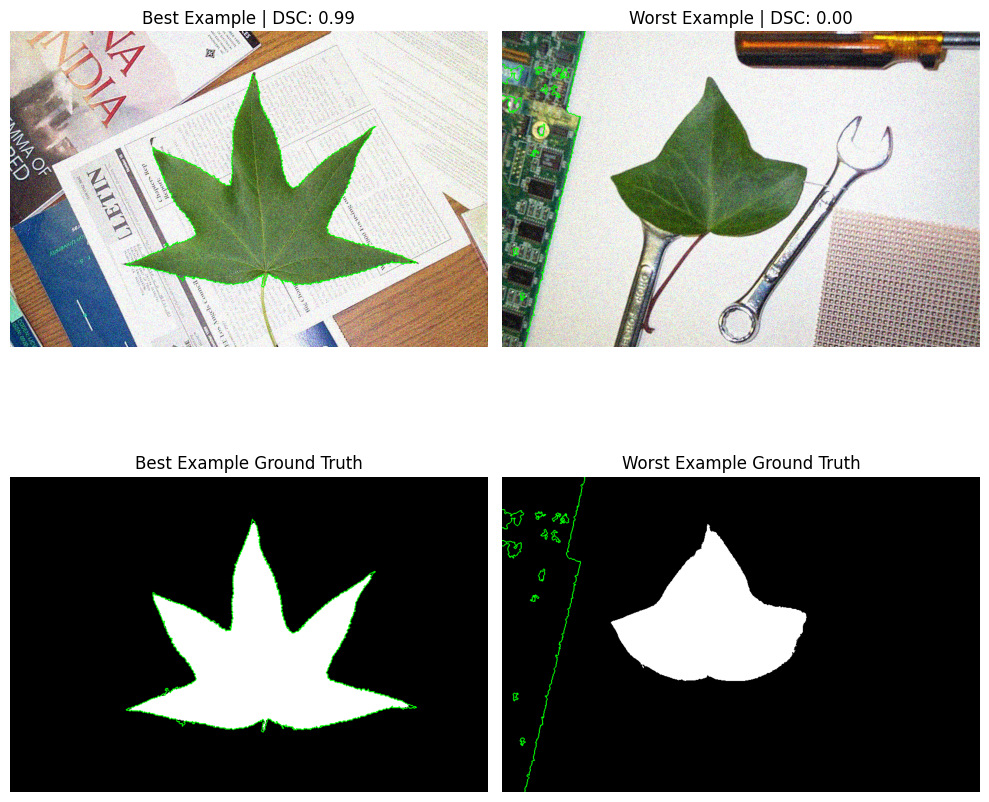

In [338]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(mark_boundaries(best_image, best_segmentation, color=(0, 1, 0), mode='thick'))
axes[0, 0].set_title(f'Best Example | DSC: {df.loc[best_idx, "DSC"]:.2f}')

axes[0, 1].imshow(mark_boundaries(worst_image, worst_segmentation, color=(0, 1, 0), mode='thick'))
axes[0, 1].set_title(f'Worst Example | DSC: {df.loc[worst_idx, "DSC"]:.2f}')

axes[1, 0].imshow(mark_boundaries(best_gt, best_segmentation, color=(0, 1, 0), mode='thick'))
axes[1, 0].set_title('Best Example Ground Truth')

axes[1, 1].imshow(mark_boundaries(worst_gt, worst_segmentation, color=(0, 1, 0), mode='thick'))
axes[1, 1].set_title('Worst Example Ground Truth')

for ax in axes.ravel():
    ax.axis('off')
    
plt.tight_layout()
plt.show()

# Step 4: Reflection

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	_Your answer:_ Similar to the previous assignment, the algorithm segments the green leaf area from an RGB image. It uses the HSV color space (because it is more intuitive to threshold) to set markers for the background and the leaf. The random walker algorithm is then applied to segment the leaf. Finally, some post-processing is done to remove small holes and objects that are not the leaf. If there are still more than one object detected, the largest connected component is kept.

2. Consider your good result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	_Your answer:_  The DSC obtained was `0.99`, which is very close to the perfect value of `1`. The algorithm performed very well on this image, but if we wanted to try to improve it, we could try to adjust the markers for the leaf to be more accurate or change the beta argument of the random walker algorithm to penalize more the pixels that are not well classified (which are the tips of the leaf).

3. Consider your bad result.  What is it about your algoirthm caused the poor performance on this image?   If you weren't able to get any results, leave this blank.

	_Your answer:_ The worst DSC obtained was `0.00`. The algorithm failed to segment the leaf from the background. The main reason obviously is that the markers for the leaf were not set correctly. The leaf is green but so is the PCB on the left side, probably both objects got markers for foreground but the area of the PCB is much larger than the leaf. Tried to adjust the values to solve the problem with this specific image, but it was not enough, it would make all the other images considerably worse. So 1 miss-classified image can be ignored if the others are good (which I think they are).
